# EDAのまとめ

## ルール

さまざまな地域にある45のWalmartストアの過去の売上データが提供されています。 各店舗には多数の部門が含まれており、各店舗の部門全体の売上を予測するのはあなたです。

Walmartは年間を通じていくつかのプロモーション値下げイベントを開催しています。 これらの値下げは著名な休日に先立ち、そのうち4つの大きなものはスーパーボウル、労働者の日、感謝祭、そしてクリスマスです。 これらの休日を含む週は、休日以外の週よりも評価が5倍高くなります。 このコンペティションで提示される課題の一部は、完全な/理想的な履歴データがない場合の、これらの休日の週における値下げの影響をモデル化することです。

### 解釈

- シンプルに考えれば、(店舗-store)(部門-department)(日付-date)とFeatureのデータを入力として、WeeklySalesを予測する。
- promotion markdownが存在して、それを考慮したらより複雑なモデルになる

## Shape

- Train shape: (421570, 5)
- Stores shape: (45, 3)
- Features shape: (8190, 12)
- Test shape: (115064, 4)



## Columns

- Train col ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']
- Stores col ['Store', 'Type', 'Size']
- Features col ['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']
- Test col ['Store', 'Dept', 'Date', 'IsHoliday']

```
FuelPrice --- その地域の燃費量
MarkDown1-5 --- walmartが実施しているプロモーション値下げに関連する匿名データ。 2011年１１月以降利用でき、すべての店舗で使えるわけじゃない。欠損値はNA
CPI --- 消費者物価指数(consumer price index)
unemployment --- 失業率
IsHoliday --- 休日か否か
```

## headとtail

- trainとfeatureのdateは同じ
- trainのdateが終わってからtestのheadが始まる
- testのtailとfeatureのtailの時期が同じ

## 疑問

- train/testの45storeのデータ数は同じなのか？
    - train_df.groupby("Store").describe()
    - 全然違う
- train/testとfeatureはどこで欠損してるのか
- MarkDown1-5がどういうデータになっているのか
- 2011/11以前のスペシャル休日をどうやって対処すべきか(普通にFalseになってるか)
    - 確認する
- [確認]スペシャル休日はIsHolidayになっているのか


## 方針

- Weekly Salesの高い順に並べて、日付を確認しスペシャル休日が高いかどうか確認し、カテゴリカル変数として定義する
- 店のタイプ、店舗、部門、月、休日が同じものは売上が近いという仮定から、売上の中央値を計算し、新たな変数として用意する。
- 直接、売上を予測するより、中央値から売上を減算したものを予測することによって、変動幅が低く予測しやすいという仮定から、中央値から売上を減算したものをターゲット変数とし、テストではこれを予測する。
- 入力にカテゴリカル変数と連続変数が多く混在していたり、ターゲット変数に正規性、他の変数との線形性、等分散性などが見れないので、ニューラルネットワークを使わず、Treeモデルを使う。LightGBM。
- ハイパーパラメータの調整はoputunaに任せる。

## 実験結果

- バリデーション用に分けたデータの売上と、予測した売上が線形関係にあるので予測できていると言える。
- 最終スコア: 3240.91122
- CPIなどの特徴量を用いたスコア: 3318.86946
- 一週間前の売上や成長率を用いたスコア: 3580.87723

## 考察と感想

- 特徴量として、CPIや気温などは大きな役割を果たさないこともわかった。
- ディスカッションでは、成長率などを予測に用いたそうだが、上手く行かなかった。
- ニューラルネットワークなどのモデルを用いる際に、前提となる「ターゲット自体の正規性」「ターゲットと他の変数との線形性、等分散性」を見つけれなかったので、モデルとしてニューラルネットワークを使うことを断念した。
- 時系列データではあるので、LSTMやARIMAなどの時系列モデルを用いるべきであったが、ツリーモデルでも十分学習できることができた。
- テーブルデータのコンペをあまりやってこなかったので、いい勉強になった。

## 参考にしたkernel

- [TP2 - Walmart Sales Forecast](https://www.kaggle.com/andredornas/tp2-walmart-sales-forecast)
- [Walmart_baseline_sales_forecasting(LSTM)](https://www.kaggle.com/nsawal/walmart-baseline-sales-forecasting-lstm)
- [Cracking the Walmart Sales Forecasting challenge](https://www.kaggle.com/fernandol/cracking-the-walmart-sales-forecasting-challenge/#data)
- [Python: LightGBM を使ってみる](https://blog.amedama.jp/entry/2018/05/01/081842)


In [1]:
#Really need these
import pandas as pd 
import numpy as np
from numpy import *


#Handy for debugging
import gc
import time
import warnings
import os

#Date stuff
from datetime import datetime
from datetime import timedelta

#Do some statistics
# from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss
import math

#Nice graphing tools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#Machine learning tools
import lightgbm as lgb
from sklearn.utils.validation import check_X_y, check_is_fitted
# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# For Hyperparameters
import optuna

## Performance measures
from sklearn.metrics import mean_squared_error

from pathlib import Path

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
from subprocess import check_output
pd.set_option('display.max_columns', 100)

## Dataの読み込み

In [2]:
datasets = Path("../datasets/")
datasets_list = list(datasets.iterdir())
stores_df = pd.read_csv(datasets_list[0])
features_df = pd.read_csv(datasets_list[1])
sample_df = pd.read_csv(datasets_list[2])
test_df = pd.read_csv(datasets_list[3])
train_df = pd.read_csv(datasets_list[4])

In [3]:
train_df = pd.merge(train_df, features_df, on=['Store','Date','IsHoliday'], how='inner')
train_df = pd.merge(train_df, stores_df, on=['Store'],how='inner')
train_df['Phase'] = "train"
test_df = pd.merge(test_df, features_df, on=['Store','Date','IsHoliday'], how='inner')
test_df = pd.merge(test_df, stores_df, on=['Store'],how='inner')
test_df['Phase'] = "test"
train_df['Date'] = pd.to_datetime(train_df['Date'], format="%Y-%m-%d")
test_df['Date'] = pd.to_datetime(test_df['Date'], format="%Y-%m-%d")

学習データとテストデータを一括で処理するために、mergeする

In [4]:
df = pd.concat([train_df, test_df], axis=0)

/home/reon/.anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




## EDA

### データの内容の確認

In [5]:
display(train_df.head(), train_df.tail()) # Train data

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Phase
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,train
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,train
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,train
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,train
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,train


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Phase
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,train
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,train
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,train
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,train
421569,45,98,2012-10-26,1076.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,train


In [6]:
display(test_df.head(), test_df.tail()) # Test data

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Phase
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,test
1,1,2,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,test
2,1,3,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,test
3,1,4,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,test
4,1,5,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,test


,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Phase
115059,45,93,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,test
115060,45,94,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,test
115061,45,95,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,test
115062,45,97,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,test
115063,45,98,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,test


- 学習データとテストデータの日付は繋がっている。

### データの欠損率

In [7]:
train_df.isnull().sum() / train_df.shape[0]

Store           0.000000
Dept            0.000000
Date            0.000000
Weekly_Sales    0.000000
IsHoliday       0.000000
Temperature     0.000000
Fuel_Price      0.000000
MarkDown1       0.642572
MarkDown2       0.736110
MarkDown3       0.674808
MarkDown4       0.679847
MarkDown5       0.640790
CPI             0.000000
Unemployment    0.000000
Type            0.000000
Size            0.000000
Phase           0.000000
dtype: float64

- 学習データの値下げ(`MarkDown1~5`)は半分以上が欠損している。

In [8]:
test_df.isnull().sum() / test_df.shape[0]

Store           0.000000
Dept            0.000000
Date            0.000000
IsHoliday       0.000000
Temperature     0.000000
Fuel_Price      0.000000
MarkDown1       0.001295
MarkDown2       0.248792
MarkDown3       0.085422
MarkDown4       0.112007
MarkDown5       0.000000
CPI             0.331659
Unemployment    0.331659
Type            0.000000
Size            0.000000
Phase           0.000000
dtype: float64

- テストデータの値下げが学習データほど欠損していないが、消費者物価指数(consumer price index)と失業率は3割近く欠損してる。

### 単変量解析

外れ値を調べるため、売上の標準化を行なったあとに、最低値と最高値を出力する

In [9]:
weekly_sales_std = StandardScaler().fit_transform(train_df.Weekly_Sales[:,np.newaxis])
low_range = weekly_sales_std[weekly_sales_std[:,0].argsort()][:10]
high_range = weekly_sales_std[weekly_sales_std[:,0].argsort()][-10:]
print('Out range (low) of the distribution:')
print(low_range)
print('\nOuter range (high) of the distribution:')
print(high_range)

Out range (low) of the distribution:
[[-0.92334347]
 [-0.87645286]
 [-0.78072898]
 [-0.77848339]
 [-0.76186072]
 [-0.75202062]
 [-0.75202062]
 [-0.75202062]
 [-0.74810008]
 [-0.74321438]]

Outer range (high) of the distribution:
[[16.63164712]
 [17.09572872]
 [17.21653278]
 [17.81526671]
 [17.89098633]
 [20.18166007]
 [26.94630146]
 [27.07999171]
 [27.90650135]
 [29.81433814]]


In [10]:
print("Skewness: %f" % train_df.Weekly_Sales.skew())
print("Kurtosis: %f" % train_df.Weekly_Sales.kurt())

Skewness: 3.262008
Kurtosis: 21.491290


値が平均0に近いものほど売上が少なく、平均0から離れた値ほど売上があったといえる。

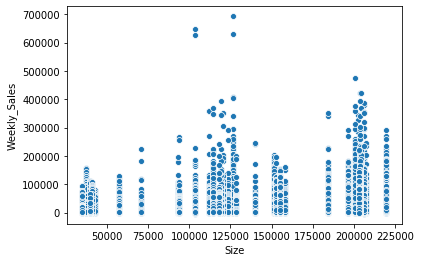

In [11]:
#bivariate analysis saleprice/grlivarea
sns.scatterplot(x='Size', y='Weekly_Sales',data=train_df)
# ax = sns.scatterplot(x="total_bill", y="tip", data=tips)

- サイズが大きくなるにつれて、売上が高くなっていることが確認できる。
- このサイズの中央値あたりで異常に売上が高くなっているものが確認できるが、外れ値であるか続けて調査する

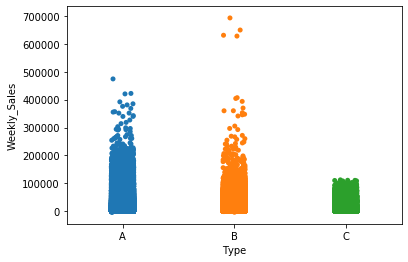

In [12]:
sns.stripplot(x='Type', y='Weekly_Sales', data=train_df)

- 店のタイプにおいて、A, BがCより明らかに高くなっていることが確認できる。

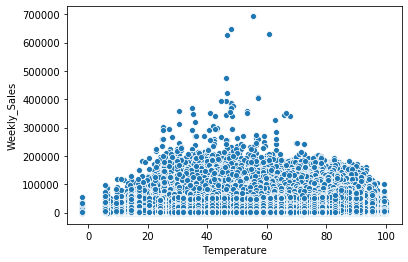

In [13]:
sns.scatterplot(x='Temperature', y='Weekly_Sales',data=train_df)

- 気温が著しく低かったり、高かったりすると売上が下がることがわかる。

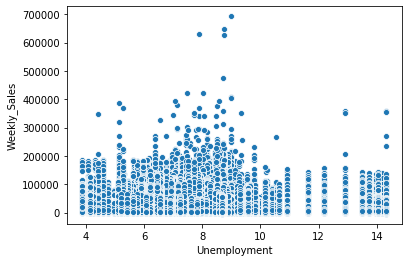

In [14]:
sns.scatterplot(x='Unemployment', y='Weekly_Sales',data=train_df)

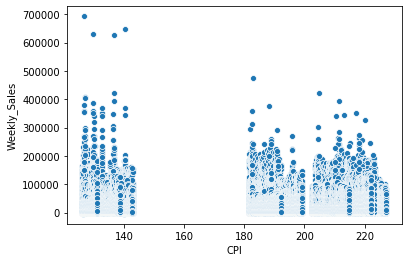

In [15]:
sns.scatterplot(x='CPI', y='Weekly_Sales',data=train_df)

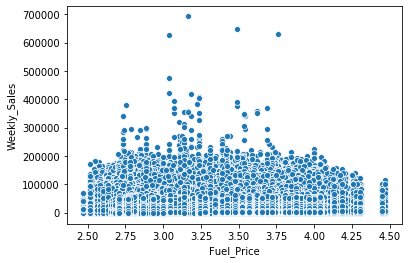

In [16]:
sns.scatterplot(x="Fuel_Price", y="Weekly_Sales", data=train_df)

- 売上とUnemplolyment, CPI, Fuel Priceの関係が見えない(ような気がする)ので、特徴量から外す

### ターゲット変数の正規性

,0
count,4.215700e+05
mean,-1.348374e-18
std,1.000001e+00
min,-9.233435e-01
25%,-6.121048e-01
50%,-3.685073e-01
75%,1.860141e-01
max,2.981434e+01


,0
count,4.215700e+05
mean,6.202522e-18
std,1.000001e+00
min,-9.233435e-01
25%,-6.121048e-01
50%,-3.685073e-01
75%,1.860141e-01
max,2.981434e+01


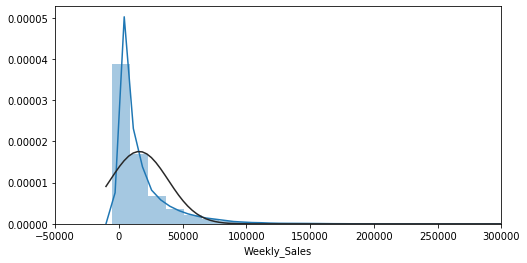

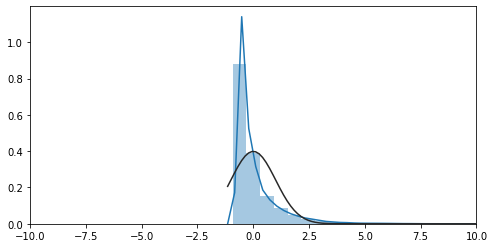

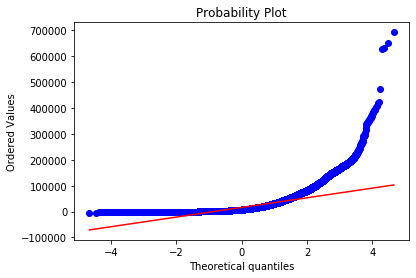

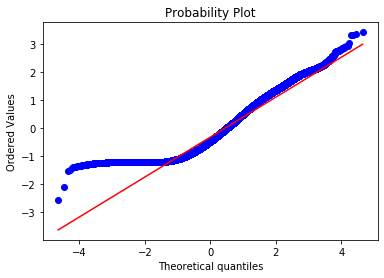

In [17]:
fig = plt.figure(figsize=(8, 4))
sns.distplot(train_df['Weekly_Sales'], fit=ss.norm)
plt.xlim((-50_000, 300_000))

fig = plt.figure(figsize=(8, 4))
std_weekly_sales = StandardScaler().fit_transform(train_df['Weekly_Sales'][:, np.newaxis])
sns.distplot(std_weekly_sales, fit=ss.norm)
plt.xlim((-10, 10))

fig = plt.figure()
res = ss.probplot(train_df['Weekly_Sales'], plot=plt)

fig = plt.figure()
logstd_weekly_sales = np.log(std_weekly_sales + 1.)
res = ss.probplot(logstd_weekly_sales.ravel(), plot=plt)
# display(train_df["Weekly_Sales"].describe())
# display(pd.DataFrame(std_weekly_sales + 1.).describe())

ws = np.exp(logstd_weekly_sales) - 1.
display(pd.DataFrame(std_weekly_sales).describe())
display(pd.DataFrame(ws).describe())

売上には、正規性はないように見える。`StandardScalar`と`np.log`を使うことによって、正規性を従うように見えるが、実際従っているか確かめれないのでターゲット変数に書き換えるのは困難である。

### 変数の相関関係

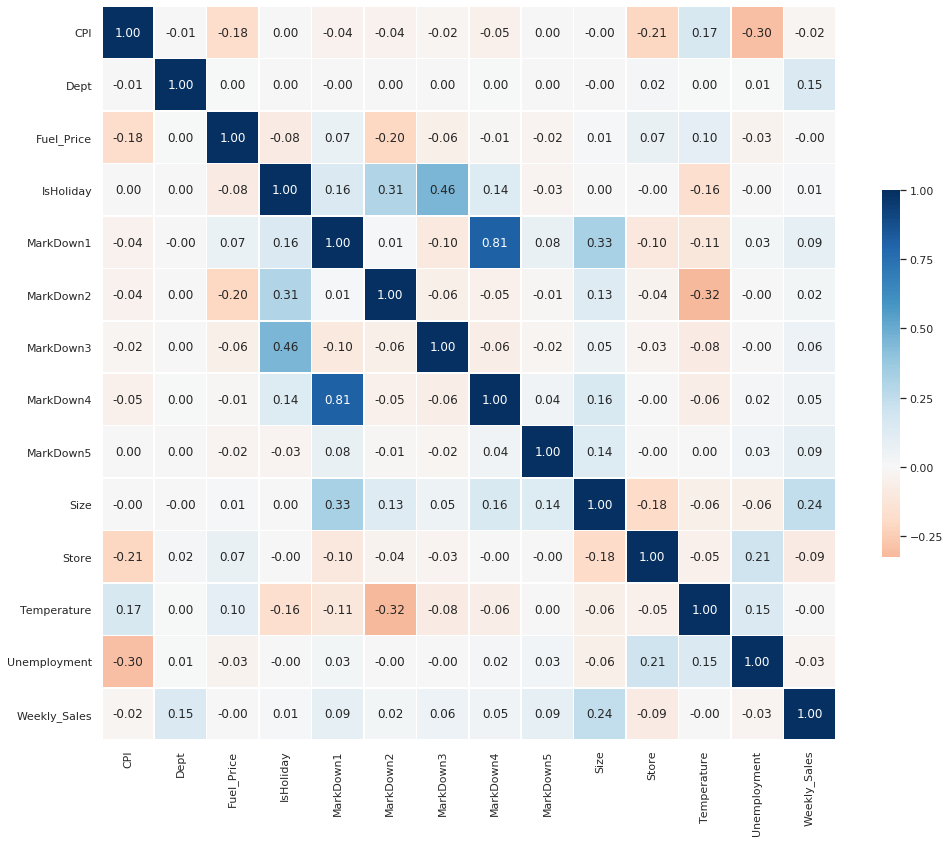

In [18]:
sns.set(style="dark")
corr = df.corr()
f, ax = plt.subplots(figsize=(11 * 1.5, 9 * 1.5))
cmap = plt.cm.RdBu
sns.heatmap(corr, cmap=cmap, vmax=1., center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt="1.2f")

いちばん重要な週売上に相関のあるものとして、

1. 大規模な店舗(Size)ほど売上に関与していることがわかる。
2. 部門数(Dept)が多いほど、売上が高いことがわかる。
3. 割引(MarkDown1~5)は通常より売上に貢献していることがわかる。
4. 休日、気温、燃料価格は大きく売上に相関がないことがわかる。

### Special 休日と売上の関係

In [19]:
train_df.sort_values(["Weekly_Sales"], ascending=[False])["Date"].head(100).value_counts()

2011-11-25    25
2010-11-26    25
2010-12-24    25
2011-12-23    13
2010-12-17     3
2010-02-05     2
2010-12-10     1
2012-04-06     1
2012-02-10     1
2011-10-07     1
2011-02-11     1
2011-08-26     1
2011-12-09     1
Name: Date, dtype: int64

- ブラックフライデー: 11月の第4木曜日の翌日にあたる日のことである。小売店などで大規模な安売りが実施される。 (Wikipedia)
- クリスマスイブ: 12/24

売上を大きい順に並べると、ブラックフライデー(11月25日、11月26日)と、クリスマスイブ(12月23日、12月24日)が大きいことが確認できた。なので、これらの日を特別な変数として、ダミー変数を作る。

### 外れ値

## Feature Engineering

### 値下げの欠損部分をダミー変数で説明する

In [20]:
df = df.assign(md1_exists = df.MarkDown1.notnull())
df = df.assign(md2_exists = df.MarkDown2.notnull())
df = df.assign(md3_exists = df.MarkDown3.notnull())
df = df.assign(md4_exists = df.MarkDown4.notnull())
df = df.assign(md5_exists = df.MarkDown5.notnull())

In [21]:
df.md1_exists = df.md1_exists.map(int)
df.md2_exists = df.md2_exists.map(int)
df.md3_exists = df.md3_exists.map(int)
df.md4_exists = df.md4_exists.map(int)
df.md5_exists = df.md5_exists.map(int)
df.head()[["md{}_exists".format(i) for i in range(1, 6)]]

,md1_exists,md2_exists,md3_exists,md4_exists,md5_exists
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


### 欠損値を0埋める

In [22]:
df.fillna(0, inplace=True)
df.isnull().sum()

CPI             0
Date            0
Dept            0
Fuel_Price      0
IsHoliday       0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
Phase           0
Size            0
Store           0
Temperature     0
Type            0
Unemployment    0
Weekly_Sales    0
md1_exists      0
md2_exists      0
md3_exists      0
md4_exists      0
md5_exists      0
dtype: int64

### スペシャル休日のダミー変数を追加する

In [23]:
# 2010-12-24    25
# 2011-12-23    13

df['BlackFriday'] = np.where((df['Date']==datetime(2010, 11, 26).date()) | 
                          (df['Date']==datetime(2011, 11, 25).date()) |
                          (df['Date']==datetime(2012, 11, 23).date())
                          ,'True', 'False')
df['Christmas'] = np.where((df['Date']==datetime(2010, 12, 23).date()) | 
                           (df['Date']==datetime(2010, 12, 24).date()) | 
                           (df['Date']==datetime(2011, 12, 23).date()) | 
                           (df['Date']==datetime(2011, 12, 24).date()) |
                           (df['Date']==datetime(2012, 12, 23).date()) | 
                           (df['Date']==datetime(2012, 12, 24).date())
                           , 'True', 'False')
df['BlackFriday'] = 'Black_Friday_' + df['BlackFriday'].map(str)
df['Christmas'] = 'Christmas_' + df['Christmas'].map(str)
df['IsHoliday'] = 'IsHoliday_' + df['IsHoliday'].map(str)

holiday_dummies = pd.get_dummies(df['IsHoliday'])
black_Friday_dummies = pd.get_dummies(df['BlackFriday'])
christmas_dummies = pd.get_dummies(df['Christmas'] )

/home/reon/.anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.

/home/reon/.anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.

/home/reon/.anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning:

Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' i

### Typeのダミー変数を追加する

In [24]:
df.Type = 'Type_' + df.Type.map(str)
display(df.Type.unique())
type_dummies = pd.get_dummies(df.Type)

array(['Type_A', 'Type_B', 'Type_C'], dtype=object)

In [25]:
df = pd.concat([df, holiday_dummies, black_Friday_dummies, christmas_dummies, type_dummies],axis=1)

In [26]:
df.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Phase,Size,Store,Temperature,Type,Unemployment,Weekly_Sales,md1_exists,md2_exists,md3_exists,md4_exists,md5_exists,BlackFriday,Christmas,IsHoliday_False,IsHoliday_True,Black_Friday_False,Black_Friday_True,Christmas_False,Christmas_True,Type_A,Type_B,Type_C
0,211.096358,2010-02-05,1,2.572,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,train,151315,1,42.31,Type_A,8.106,24924.50,0,0,0,0,0,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0
1,211.096358,2010-02-05,2,2.572,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,train,151315,1,42.31,Type_A,8.106,50605.27,0,0,0,0,0,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0
2,211.096358,2010-02-05,3,2.572,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,train,151315,1,42.31,Type_A,8.106,13740.12,0,0,0,0,0,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0
3,211.096358,2010-02-05,4,2.572,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,train,151315,1,42.31,Type_A,8.106,39954.04,0,0,0,0,0,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0
4,211.096358,2010-02-05,5,2.572,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,train,151315,1,42.31,Type_A,8.106,32229.38,0,0,0,0,0,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0


In [27]:
df["Month"] = [date.month for date in df.Date]

In [28]:
df.tail()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Phase,Size,Store,Temperature,Type,Unemployment,Weekly_Sales,md1_exists,md2_exists,md3_exists,md4_exists,md5_exists,BlackFriday,Christmas,IsHoliday_False,IsHoliday_True,Black_Friday_False,Black_Friday_True,Christmas_False,Christmas_True,Type_A,Type_B,Type_C,Month
115059,0.0,2013-07-26,93,3.804,IsHoliday_False,212.02,851.73,2.06,10.88,1864.57,test,118221,45,76.06,Type_B,0.0,0.0,1,1,1,1,1,Black_Friday_False,Christmas_False,1,0,1,0,1,0,0,1,0,7
115060,0.0,2013-07-26,94,3.804,IsHoliday_False,212.02,851.73,2.06,10.88,1864.57,test,118221,45,76.06,Type_B,0.0,0.0,1,1,1,1,1,Black_Friday_False,Christmas_False,1,0,1,0,1,0,0,1,0,7
115061,0.0,2013-07-26,95,3.804,IsHoliday_False,212.02,851.73,2.06,10.88,1864.57,test,118221,45,76.06,Type_B,0.0,0.0,1,1,1,1,1,Black_Friday_False,Christmas_False,1,0,1,0,1,0,0,1,0,7
115062,0.0,2013-07-26,97,3.804,IsHoliday_False,212.02,851.73,2.06,10.88,1864.57,test,118221,45,76.06,Type_B,0.0,0.0,1,1,1,1,1,Black_Friday_False,Christmas_False,1,0,1,0,1,0,0,1,0,7
115063,0.0,2013-07-26,98,3.804,IsHoliday_False,212.02,851.73,2.06,10.88,1864.57,test,118221,45,76.06,Type_B,0.0,0.0,1,1,1,1,1,Black_Friday_False,Christmas_False,1,0,1,0,1,0,0,1,0,7


### 売上の中央値を変数として追加する

In [31]:
median_sales = pd.DataFrame({"MedianSales": df[df['Phase']=='train'].groupby(by=['Type','Dept','Store','Month','IsHoliday'])['Weekly_Sales'].median()}).reset_index()

In [32]:
median_sales.head()

,Type,Dept,Store,Month,IsHoliday,MedianSales
0,Type_A,1,1,1,IsHoliday_False,17350.585
1,Type_A,1,1,2,IsHoliday_False,23510.490
2,Type_A,1,1,2,IsHoliday_True,37887.170
3,Type_A,1,1,3,IsHoliday_False,21280.400
4,Type_A,1,1,4,IsHoliday_False,26318.080


In [33]:
df = df.merge(median_sales, on=["Type", "Dept", "Store", "Month", "IsHoliday"], how="outer")

学習データの売上の中央値のすべての中央値を埋め合わせする

In [34]:
df.MedianSales =  df.MedianSales.fillna(df[df["Phase"] == "train"].MedianSales.median())
df.tail()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Phase,Size,Store,Temperature,Type,Unemployment,Weekly_Sales,md1_exists,md2_exists,md3_exists,md4_exists,md5_exists,BlackFriday,Christmas,IsHoliday_False,IsHoliday_True,Black_Friday_False,Black_Friday_True,Christmas_False,Christmas_True,Type_A,Type_B,Type_C,Month,MedianSales
536629,0.000000,2013-06-14,44,3.771,IsHoliday_False,351.38,0.0,4.89,6.35,867.28,test,39910,44,76.41,Type_C,0.000,0.0,1,0,1,1,1,Black_Friday_False,Christmas_False,1,0,1,0,1,0,0,0,1,6,7563.04
536630,0.000000,2013-07-12,22,3.666,IsHoliday_False,182.25,0.0,6.63,0.00,1842.48,test,39910,44,78.93,Type_C,0.000,0.0,1,0,1,0,1,Black_Friday_False,Christmas_False,1,0,1,0,1,0,0,0,1,7,7563.04
536631,0.000000,2013-07-19,22,3.665,IsHoliday_False,118.82,0.0,3.15,0.00,514.08,test,39910,44,80.81,Type_C,0.000,0.0,1,0,1,0,1,Black_Friday_False,Christmas_False,1,0,1,0,1,0,0,0,1,7,7563.04
536632,0.000000,2013-07-26,22,3.669,IsHoliday_False,134.31,0.0,1.00,0.00,199.75,test,39910,44,83.62,Type_C,0.000,0.0,1,0,1,0,1,Black_Friday_False,Christmas_False,1,0,1,0,1,0,0,0,1,7,7563.04
536633,193.589304,2013-04-26,39,3.615,IsHoliday_False,1260.65,0.0,57.52,40.51,2476.18,test,118221,45,50.64,Type_B,8.335,0.0,1,0,1,1,1,Black_Friday_False,Christmas_False,1,0,1,0,1,0,0,1,0,4,7563.04


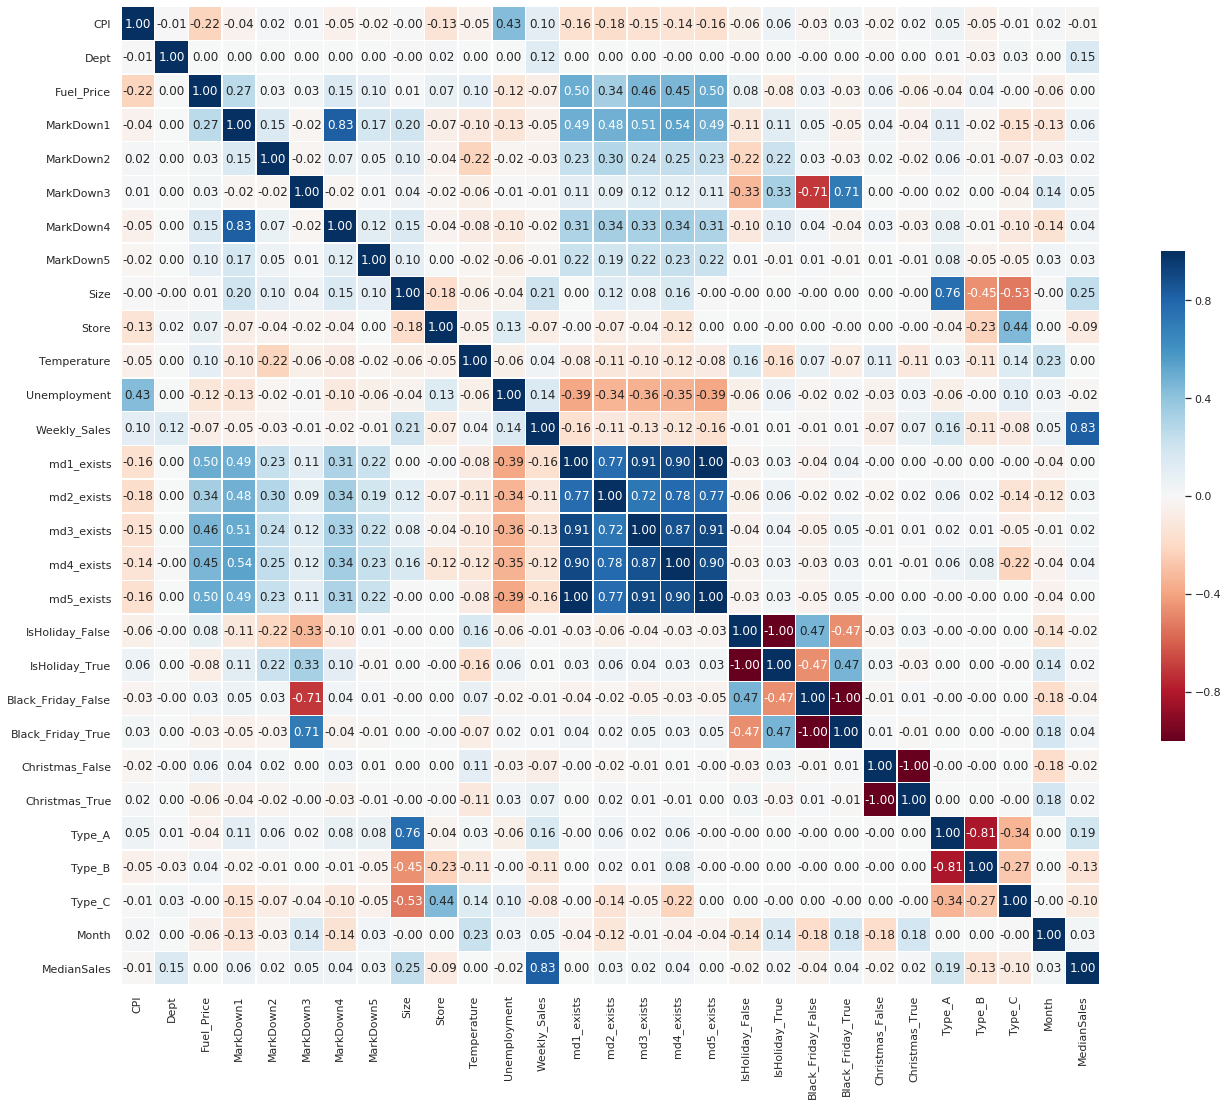

In [35]:
sns.set(style="dark")
corr = df.corr()
f, ax = plt.subplots(figsize=(11 * 2., 9 * 2.))
cmap = plt.cm.RdBu
sns.heatmap(corr, cmap=cmap, vmax=1., center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt="1.2f")

In [36]:
pd.value_counts(df["Weekly_Sales"] > 0)

True     420212
False    116422
Name: Weekly_Sales, dtype: int64

### 一週間前の売りあげを特徴量に追加する

In [37]:
display((df.Date - timedelta(7)).head(), df.Date.head())

0   2010-01-29
1   2010-02-12
2   2010-02-19
3   2011-01-28
4   2011-02-11
Name: Date, dtype: datetime64[ns]

0   2010-02-05
1   2010-02-19
2   2010-02-26
3   2011-02-04
4   2011-02-18
Name: Date, dtype: datetime64[ns]

In [38]:
df["LastWeekDate"] = df.Date - timedelta(7)

In [39]:
df_ = df.copy().sort_values(["Store", "Dept", "Date"]).reset_index(drop=True)

In [40]:
df_.loc[0]

CPI                               211.096
Date                  2010-02-05 00:00:00
Dept                                    1
Fuel_Price                          2.572
IsHoliday                 IsHoliday_False
MarkDown1                               0
MarkDown2                               0
MarkDown3                               0
MarkDown4                               0
MarkDown5                               0
Phase                               train
Size                               151315
Store                                   1
Temperature                         42.31
Type                               Type_A
Unemployment                        8.106
Weekly_Sales                      24924.5
md1_exists                              0
md2_exists                              0
md3_exists                              0
md4_exists                              0
md5_exists                              0
BlackFriday            Black_Friday_False
Christmas                 Christma

In [42]:
from tqdm import tqdm
df_["LastWeeklySales"] = np.NaN
df_["ValidLastSales"] = np.NaN
# df_["WeeklyGrowth"] = np.NaN
last_row = df_.loc[0]
for index, row in tqdm(df_.iterrows()):
    if last_row.Date == row.LastWeekDate and last_row.Weekly_Sales > 0:
        df_.at[index, "LastWeeklySales"] = last_row.Weekly_Sales
        df_.at[index, "ValidLastSales"] = 1
    else:
        df_.at[index, "LastWeeklySales"] = last_row.MedianSales
        df_.at[index, "ValidLastSales"] = 0
    last_row = row 

536634it [01:12, 7447.94it/s]


### 一週間前との売上からの成長率を特徴量に追加する

In [93]:
std_median_sales = StandardScaler().fit_transform(df_.MedianSales[:, np.newaxis])
std_last_week_sales =  StandardScaler().fit_transform(df_.LastWeeklySales[:, np.newaxis])
df_["WeeklyGrowth"] = std_median_sales / std_last_week_sales
df_.describe()

,CPI,Dept,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Store,Temperature,Unemployment,Weekly_Sales,md1_exists,md2_exists,md3_exists,md4_exists,md5_exists,IsHoliday_False,IsHoliday_True,Black_Friday_False,Black_Friday_True,Christmas_False,Christmas_True,Type_A,Type_B,Type_C,Month,MedianSales,LastWeeklySales,ValidLastSales,WeeklyGrowth,ValidGrowth
count,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.00000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000
mean,159.852499,44.277301,3.408310,3681.287709,1292.745138,838.971725,1489.918846,2147.337557,136678.55096,22.208621,58.771762,7.237779,12554.588392,0.494930,0.368380,0.451567,0.441908,0.496607,0.928091,0.071909,0.983350,0.016650,0.988851,0.011149,0.510946,0.387592,0.101462,6.295203,15774.376768,15970.572673,0.773412,1.023272,0.998489
std,58.383773,30.527358,0.430861,7593.883000,5714.136207,7860.456173,4865.593575,9789.902903,61007.71180,12.790580,18.678716,2.691035,21171.249456,0.499975,0.482366,0.497649,0.496614,0.499989,0.258338,0.258338,0.127957,0.127957,0.104999,0.104999,0.499881,0.487201,0.301940,3.333808,22260.353423,22688.833805,0.418624,60.489634,0.038846
min,0.000000,1.000000,2.472000,-2781.450000,-265.760000,-179.260000,0.000000,-185.170000,34875.00000,1.000000,-7.290000,0.000000,-4988.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1750.000000,-1750.000000,0.000000,-25753.168428,0.000000
25%,131.126667,18.000000,3.041000,0.000000,0.000000,0.000000,0.000000,0.000000,93638.00000,11.000000,45.250000,6.334000,49.852500,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2104.370000,2103.882500,1.000000,0.955811,1.000000
50%,140.439786,37.000000,3.523000,0.000000,0.000000,0.000000,0.000000,0.000000,140167.00000,22.000000,60.060000,7.567000,4118.755000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,6.000000,7568.680000,7608.915000,1.000000,1.005533,1.000000
75%,212.303441,74.000000,3.744000,5046.740000,118.730000,29.140000,906.450000,2852.190000,202505.00000,33.000000,73.230000,8.512000,15497.417500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,9.000000,20018.285000,20186.105000,1.000000,1.043369,1.000000
max,228.976456,99.000000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,219622.00000,45.000000,101.950000,14.313000,693099.360000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,662049.275000,693099.360000,1.000000,30567.107181,1.000000


In [94]:
df_["ValidGrowth"] = (df_.MedianSales > 0) * 1.
df_.loc[df_["WeeklyGrowth"] < 0, "WeeklyGrowth"] = 0
df_["WeeklyGrowth"] = np.log(df_.WeeklyGrowth + 1.)

In [95]:
df_.describe()

,CPI,Dept,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Store,Temperature,Unemployment,Weekly_Sales,md1_exists,md2_exists,md3_exists,md4_exists,md5_exists,IsHoliday_False,IsHoliday_True,Black_Friday_False,Black_Friday_True,Christmas_False,Christmas_True,Type_A,Type_B,Type_C,Month,MedianSales,LastWeeklySales,ValidLastSales,WeeklyGrowth,ValidGrowth
count,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.00000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000
mean,159.852499,44.277301,3.408310,3681.287709,1292.745138,838.971725,1489.918846,2147.337557,136678.55096,22.208621,58.771762,7.237779,12554.588392,0.494930,0.368380,0.451567,0.441908,0.496607,0.928091,0.071909,0.983350,0.016650,0.988851,0.011149,0.510946,0.387592,0.101462,6.295203,15774.376768,15970.572673,0.773412,0.692160,0.998489
std,58.383773,30.527358,0.430861,7593.883000,5714.136207,7860.456173,4865.593575,9789.902903,61007.71180,12.790580,18.678716,2.691035,21171.249456,0.499975,0.482366,0.497649,0.496614,0.499989,0.258338,0.258338,0.127957,0.127957,0.104999,0.104999,0.499881,0.487201,0.301940,3.333808,22260.353423,22688.833805,0.418624,0.268158,0.038846
min,0.000000,1.000000,2.472000,-2781.450000,-265.760000,-179.260000,0.000000,-185.170000,34875.00000,1.000000,-7.290000,0.000000,-4988.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1750.000000,-1750.000000,0.000000,0.000000,0.000000
25%,131.126667,18.000000,3.041000,0.000000,0.000000,0.000000,0.000000,0.000000,93638.00000,11.000000,45.250000,6.334000,49.852500,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2104.370000,2103.882500,1.000000,0.670805,1.000000
50%,140.439786,37.000000,3.523000,0.000000,0.000000,0.000000,0.000000,0.000000,140167.00000,22.000000,60.060000,7.567000,4118.755000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,6.000000,7568.680000,7608.915000,1.000000,0.695910,1.000000
75%,212.303441,74.000000,3.744000,5046.740000,118.730000,29.140000,906.450000,2852.190000,202505.00000,33.000000,73.230000,8.512000,15497.417500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,9.000000,20018.285000,20186.105000,1.000000,0.714600,1.000000
max,228.976456,99.000000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,219622.00000,45.000000,101.950000,14.313000,693099.360000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,662049.275000,693099.360000,1.000000,10.327712,1.000000


In [76]:
df_.ValidGrowth.value_counts()

1.0    535823
0.0       811
Name: ValidGrowth, dtype: int64

In [77]:
(df_.WeeklyGrowth > 1).value_counts()

False    514876
True      21758
Name: WeeklyGrowth, dtype: int64

In [96]:
valid_growth = df_.loc[df_.ValidGrowth == 1., "WeeklyGrowth"]
valid_sales = df_.loc[df_.ValidGrowth == 1., "Weekly_Sales"]

### 成長率と売上の関係を見る

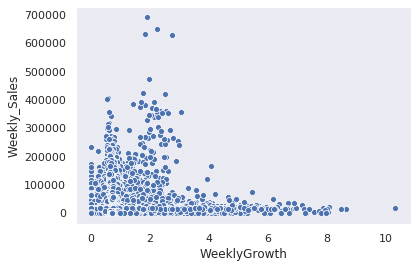

In [97]:
sns.scatterplot(valid_growth, valid_sales)

- 成長していても、必ずしも売上が高くなっているわけじゃないことがわかる

In [80]:
df_.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Phase,Size,Store,Temperature,Type,Unemployment,Weekly_Sales,md1_exists,md2_exists,md3_exists,md4_exists,md5_exists,BlackFriday,Christmas,IsHoliday_False,IsHoliday_True,Black_Friday_False,Black_Friday_True,Christmas_False,Christmas_True,Type_A,Type_B,Type_C,Month,MedianSales,LastWeekDate,LastWeeklySales,ValidLastSales,WeeklyGrowth,ValidGrowth
0,211.096358,2010-02-05,1,2.572,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,train,151315,1,42.31,Type_A,8.106,24924.50,0,0,0,0,0,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,2,23510.49,2010-01-29,23510.49,0.0,0.693147,1.0
1,211.242170,2010-02-12,1,2.548,IsHoliday_True,0.0,0.0,0.0,0.0,0.0,train,151315,1,38.51,Type_A,8.106,46039.49,0,0,0,0,0,Black_Friday_False,Christmas_False,0,1,1,0,1,0,1,0,0,2,37887.17,2010-02-05,24924.50,1.0,0.924290,1.0
2,211.289143,2010-02-19,1,2.514,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,train,151315,1,39.93,Type_A,8.106,41595.55,0,0,0,0,0,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,2,23510.49,2010-02-12,46039.49,1.0,0.412546,1.0
3,211.319643,2010-02-26,1,2.561,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,train,151315,1,46.63,Type_A,8.106,19403.54,0,0,0,0,0,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,2,23510.49,2010-02-19,41595.55,1.0,0.448024,1.0
4,211.350143,2010-03-05,1,2.625,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,train,151315,1,46.50,Type_A,8.106,21827.90,0,0,0,0,0,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,3,21280.40,2010-02-26,19403.54,1.0,0.740378,1.0


In [81]:
df.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Phase,Size,Store,Temperature,Type,Unemployment,Weekly_Sales,md1_exists,md2_exists,md3_exists,md4_exists,md5_exists,BlackFriday,Christmas,IsHoliday_False,IsHoliday_True,Black_Friday_False,Black_Friday_True,Christmas_False,Christmas_True,Type_A,Type_B,Type_C,Month,MedianSales,LastWeekDate,LastWeeklySales,ValidLastSales,WeeklyGrowth,ValidGrowth,SalesDiff,Target1
0,211.096358,2010-02-05,1,2.572,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,train,151315,1,42.31,Type_A,8.106,24924.50,0,0,0,0,0,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,2,23510.49,2010-01-29,23510.49,0.0,0.722776,1.0,0.00,-1414.01
1,211.242170,2010-02-12,1,2.548,IsHoliday_True,0.0,0.0,0.0,0.0,0.0,train,151315,1,38.51,Type_A,8.106,46039.49,0,0,0,0,0,Black_Friday_False,Christmas_False,0,1,1,0,1,0,1,0,0,2,37887.17,2010-02-05,24924.50,1.0,1.046321,1.0,12962.67,-8152.32
2,211.289143,2010-02-19,1,2.514,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,train,151315,1,39.93,Type_A,8.106,41595.55,0,0,0,0,0,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,2,23510.49,2010-02-12,46039.49,1.0,0.643681,1.0,-22529.00,-18085.06
3,211.319643,2010-02-26,1,2.561,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,train,151315,1,46.63,Type_A,8.106,19403.54,0,0,0,0,0,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,2,23510.49,2010-02-19,41595.55,1.0,0.382866,1.0,-18085.06,4106.95
4,211.350143,2010-03-05,1,2.625,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,train,151315,1,46.50,Type_A,8.106,21827.90,0,0,0,0,0,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,3,21280.40,2010-02-26,19403.54,1.0,0.753746,1.0,1876.86,-547.50


In [50]:
print(df.shape)
print(df_.shape)

(536634, 36)
(536634, 40)


In [98]:
tmp_df = df.copy()
df = df_.copy()

In [99]:
assert tmp_df.shape[0] == df.shape[0]
print(df.shape)
print(df_.shape)
print(tmp_df.shape)

(536634, 40)
(536634, 40)
(536634, 42)


In [53]:
display(pd.value_counts(df["LastWeeklySales"] > 0))
display(pd.value_counts(df["MedianSales"] > 0))

True     535875
False       759
Name: LastWeeklySales, dtype: int64

True     535823
False       811
Name: MedianSales, dtype: int64

In [103]:
df['SalesDiff'] = df['MedianSales'] - df['LastWeeklySales']

### ターゲット変数=中央値-売上とする

In [110]:
df['Target1'] = df.MedianSales - df.Weekly_Sales

In [57]:
df.columns

Index(['CPI', 'Date', 'Dept', 'Fuel_Price', 'IsHoliday', 'MarkDown1',
       'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Phase', 'Size',
       'Store', 'Temperature', 'Type', 'Unemployment', 'Weekly_Sales',
       'md1_exists', 'md2_exists', 'md3_exists', 'md4_exists', 'md5_exists',
       'BlackFriday', 'Christmas', 'IsHoliday_False', 'IsHoliday_True',
       'Black_Friday_False', 'Black_Friday_True', 'Christmas_False',
       'Christmas_True', 'Type_A', 'Type_B', 'Type_C', 'Month', 'MedianSales',
       'LastWeekDate', 'LastWeeklySales', 'ValidLastSales', 'WeeklyGrowth',
       'ValidGrowth', 'SalesDiff', 'Target1'],
      dtype='object')

## 特徴量選択

In [104]:
FEATURE_COLUMNS = [
    # 'CPI',
    # 'Unemployment',
    # 'Fuel_Price',
    'Dept',
    'MarkDown1',
    'MarkDown2',
    'MarkDown3',
    'MarkDown4',
    'MarkDown5',
    'md1_exists',
    'md2_exists',
    'md3_exists',
    'md4_exists',
    'md5_exists',    
    'Size',
    'Temperature',
    'IsHoliday_False',
    'IsHoliday_True',
    'Christmas_False',
    'Christmas_True',
    'Black_Friday_False',
    'Black_Friday_True',
    'Type_A',
    'Type_B',
    'Type_C',
    'MedianSales',
     
    'LastWeeklySales', 
    'ValidLastSales',
    'SalesDiff',
    
    'WeeklyGrowth',
    'ValidGrowth',
]

In [105]:
df[FEATURE_COLUMNS].shape

(536634, 28)

### 分散の小さなものを排除する特徴量選択

In [60]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=0.015)
sel.fit(df[FEATURE_COLUMNS])

VarianceThreshold(threshold=0.015)

In [61]:
sum(sel.get_support())

21

In [62]:
[(col, support) for col, support in zip(df[FEATURE_COLUMNS].columns, sel.get_support())]

[('Dept', True),
 ('MarkDown1', True),
 ('MarkDown2', True),
 ('MarkDown3', True),
 ('MarkDown4', True),
 ('MarkDown5', True),
 ('md1_exists', True),
 ('md2_exists', True),
 ('md3_exists', True),
 ('md4_exists', True),
 ('md5_exists', True),
 ('Size', True),
 ('Temperature', True),
 ('IsHoliday_False', True),
 ('IsHoliday_True', True),
 ('Christmas_False', False),
 ('Christmas_True', False),
 ('Black_Friday_False', True),
 ('Black_Friday_True', True),
 ('Type_A', True),
 ('Type_B', True),
 ('Type_C', True),
 ('MedianSales', True)]

- クリスマスのカテゴリカル変数の分散が非常に小さいことが伺えるが、これは非常に重要な変数なので `VarianceThreshold` を用いることをやめる。

In [106]:
display(df[FEATURE_COLUMNS].describe())
display(df[FEATURE_COLUMNS].head())

,Dept,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,md1_exists,md2_exists,md3_exists,md4_exists,md5_exists,Size,Temperature,IsHoliday_False,IsHoliday_True,Christmas_False,Christmas_True,Black_Friday_False,Black_Friday_True,Type_A,Type_B,Type_C,MedianSales,LastWeeklySales,ValidLastSales,SalesDiff,WeeklyGrowth,ValidGrowth
count,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.00000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000
mean,44.277301,3681.287709,1292.745138,838.971725,1489.918846,2147.337557,0.494930,0.368380,0.451567,0.441908,0.496607,136678.55096,58.771762,0.928091,0.071909,0.988851,0.011149,0.983350,0.016650,0.510946,0.387592,0.101462,15774.376768,15970.572673,0.773412,-196.195905,0.692160,0.998489
std,30.527358,7593.883000,5714.136207,7860.456173,4865.593575,9789.902903,0.499975,0.482366,0.497649,0.496614,0.499989,61007.71180,18.678716,0.258338,0.258338,0.104999,0.104999,0.127957,0.127957,0.499881,0.487201,0.301940,22260.353423,22688.833805,0.418624,7169.212247,0.268158,0.038846
min,1.000000,-2781.450000,-265.760000,-179.260000,0.000000,-185.170000,0.000000,0.000000,0.000000,0.000000,0.000000,34875.00000,-7.290000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1750.000000,-1750.000000,0.000000,-563064.060000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,93638.00000,45.250000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2104.370000,2103.882500,1.000000,-426.267500,0.670805,1.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,140167.00000,60.060000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,7568.680000,7608.915000,1.000000,0.000000,0.695910,1.000000
75%,74.000000,5046.740000,118.730000,29.140000,906.450000,2852.190000,1.000000,1.000000,1.000000,1.000000,1.000000,202505.00000,73.230000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,20018.285000,20186.105000,1.000000,395.853750,0.714600,1.000000
max,99.000000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,1.000000,1.000000,1.000000,1.000000,1.000000,219622.00000,101.950000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,662049.275000,693099.360000,1.000000,579251.325000,10.327712,1.000000


,Dept,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,md1_exists,md2_exists,md3_exists,md4_exists,md5_exists,Size,Temperature,IsHoliday_False,IsHoliday_True,Christmas_False,Christmas_True,Black_Friday_False,Black_Friday_True,Type_A,Type_B,Type_C,MedianSales,LastWeeklySales,ValidLastSales,SalesDiff,WeeklyGrowth,ValidGrowth
0,1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,151315,42.31,1,0,1,0,1,0,1,0,0,23510.49,23510.49,0.0,0.00,0.715774,1.0
1,1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,151315,38.51,0,1,1,0,1,0,1,0,0,37887.17,24924.50,1.0,12962.67,1.257653,1.0
2,1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,151315,39.93,1,0,1,0,1,0,1,0,0,23510.49,46039.49,1.0,-22529.00,0.232881,1.0
3,1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,151315,46.63,1,0,1,0,1,0,1,0,0,23510.49,41595.55,1.0,-18085.06,0.268276,1.0
4,1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,151315,46.50,1,0,1,0,1,0,1,0,0,21280.40,19403.54,1.0,1876.86,0.968784,1.0


In [112]:
train = df.loc[df['Phase']=='train']
test = df.loc[df['Phase']=='test']
display(test[FEATURE_COLUMNS].head())
display(test[FEATURE_COLUMNS].tail())

,Dept,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,md1_exists,md2_exists,md3_exists,md4_exists,md5_exists,Size,Temperature,IsHoliday_False,IsHoliday_True,Christmas_False,Christmas_True,Black_Friday_False,Black_Friday_True,Type_A,Type_B,Type_C,MedianSales,LastWeeklySales,ValidLastSales,SalesDiff,WeeklyGrowth,ValidGrowth
143,1,6766.44,5147.70,50.82,3639.90,2737.42,1,1,1,1,1,151315,55.32,1,0,1,0,1,0,1,0,0,19551.115,27390.810,1.0,-7839.695,0.290482,1.0
144,1,11421.32,3370.89,40.28,4646.79,6154.16,1,1,1,1,1,151315,61.24,1,0,1,0,1,0,1,0,0,19551.115,19551.115,0.0,0.000,0.730009,1.0
145,1,9696.28,292.10,103.78,1133.15,6612.69,1,1,1,1,1,151315,52.92,1,0,1,0,1,0,1,0,0,19551.115,19551.115,0.0,0.000,0.730009,1.0
146,1,883.59,4.17,74910.32,209.91,303.32,1,1,1,1,1,151315,56.23,0,1,1,0,0,1,1,0,0,19865.770,19551.115,0.0,314.655,0.772267,1.0
147,1,2460.03,0.00,3838.35,150.57,6966.34,1,0,1,1,1,151315,52.34,1,0,1,0,1,0,1,0,0,19551.115,19865.770,0.0,-314.655,0.687256,1.0


,Dept,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,md1_exists,md2_exists,md3_exists,md4_exists,md5_exists,Size,Temperature,IsHoliday_False,IsHoliday_True,Christmas_False,Christmas_True,Black_Friday_False,Black_Friday_True,Type_A,Type_B,Type_C,MedianSales,LastWeeklySales,ValidLastSales,SalesDiff,WeeklyGrowth,ValidGrowth
536629,98,4842.29,975.03,3.00,2449.97,3169.69,1,1,1,1,1,118221,76.05,1,0,1,0,1,0,0,1,0,725.43,725.43,0.0,0.0,0.696208,1.0
536630,98,9090.48,2268.58,582.74,5797.47,1514.93,1,1,1,1,1,118221,77.50,1,0,1,0,1,0,0,1,0,657.63,725.43,0.0,-67.8,0.698465,1.0
536631,98,3789.94,1827.31,85.72,744.84,2150.36,1,1,1,1,1,118221,79.37,1,0,1,0,1,0,0,1,0,657.63,657.63,0.0,0.0,0.696237,1.0
536632,98,2961.49,1047.07,204.19,363.00,1059.46,1,1,1,1,1,118221,82.84,1,0,1,0,1,0,0,1,0,657.63,657.63,0.0,0.0,0.696237,1.0
536633,98,212.02,851.73,2.06,10.88,1864.57,1,1,1,1,1,118221,76.06,1,0,1,0,1,0,0,1,0,657.63,657.63,0.0,0.0,0.696237,1.0


In [108]:
test.sort_values(by=["Store", "Dept", "Date"]).head()[["Store", "Dept", "Date"]]

,Store,Dept,Date
143,1,1,2012-11-02
144,1,1,2012-11-09
145,1,1,2012-11-16
146,1,1,2012-11-23
147,1,1,2012-11-30


### 学習用とバリデーション用に分ける

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(train[FEATURE_COLUMNS], train.Target1)
y_valid = y_valid.to_frame()

### ハイパーパラメータの最適化

In [ ]:
def opt(trial):
    n_estimators = trial.suggest_int('n_estimators', 0, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)
    num_leaves = trial.suggest_int('num_leaves', 300, 1200)
    model_opt = lgb.LGBMRegressor(
        random_state=42,
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        num_leaves = num_leaves
    )
    model_opt.fit(x_train, y_train)
    opt_pred = model_opt.predict(x_valid)
    return (1.0 - (model_opt.score(x_valid, y_valid)))

# model_opt=LGBMRegressor()
study = optuna.create_study()
optuna.logging.enable_default_handler()
study.optimize(opt, n_trials=1)

### optunaで得たパラメータで学習する

In [114]:
# best_params = {'n_estimators': 180, 'max_depth': 11, 'min_child_weight': 5, 'subsample': 0.8, 'colsample_bytree': 0.7, 'num_leaves': 572}
best_params = {'n_estimators': 850, 'max_depth': 18, 'min_child_weight': 4, 'subsample': 0.9, 'colsample_bytree': 0.7, 'num_leaves': 320, 'verbosity': 1}
model_ = lgb.LGBMRegressor(
    random_state=42,
    **best_params,
    # **study.best_params,
)
model_.fit(train[FEATURE_COLUMNS], train.Target1)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
              importance_type='split', learning_rate=0.1, max_depth=18,
              min_child_samples=20, min_child_weight=4, min_split_gain=0.0,
              n_estimators=850, n_jobs=-1, num_leaves=320, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.9, subsample_for_bin=200000, subsample_freq=0,
              verbosity=1)

### CPIなどを使わなかったときの、モデル

```python
print(study.best_params)
print(1-study.best_value)
> {'n_estimators': 850, 'max_depth': 18, 'min_child_weight': 4, 'subsample': 0.9, 'colsample_bytree': 0.7, 'num_leaves': 320}
> 0.42710110443089855
y_pred = model_.predict(x_valid)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
print(rmse)
> 2056.1479891916433
```

### CPIを使ったときのモデル

```python
> {'n_estimators': 933, 'max_depth': 20, 'min_child_weight': 8, 'subsample': 0.5, 'colsample_bytree': 0.9, 'num_leaves': 432}
> 0.5941649913027514
> 1265.6797688772026
```

- CPIなどの特徴量を用いたときのほうがvalidationの精度は高くなっていることが確認できる
- しかし、CPIなどの特徴量を使ったほうがテストケースにおいては精度が下がっていることがわかったので、特徴量として不必要であることがわかった

### モデルの評価

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Phase,Size,Store,Temperature,Type,Unemployment,Weekly_Sales,md1_exists,md2_exists,md3_exists,md4_exists,md5_exists,BlackFriday,Christmas,IsHoliday_False,IsHoliday_True,Black_Friday_False,Black_Friday_True,Christmas_False,Christmas_True,Type_A,Type_B,Type_C,Month,MedianSales,LastWeekDate,LastWeeklySales,ValidLastSales,WeeklyGrowth,ValidGrowth,SalesDiff,Target1,Predicted
1,211.242170,2010-02-12,1,2.548,IsHoliday_True,0.0,0.0,0.0,0.0,0.0,train,151315,1,38.51,Type_A,8.106,46039.49,0,0,0,0,0,Black_Friday_False,Christmas_False,0,1,1,0,1,0,1,0,0,2,37887.170,2010-02-05,24924.50,1.0,1.257653,1.0,12962.670,-8152.320,-5711.322306
3,211.319643,2010-02-26,1,2.561,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,train,151315,1,46.63,Type_A,8.106,19403.54,0,0,0,0,0,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,2,23510.490,2010-02-19,41595.55,1.0,0.268276,1.0,-18085.060,4106.950,213.755329
5,211.380643,2010-03-12,1,2.667,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,train,151315,1,57.79,Type_A,8.106,21043.39,0,0,0,0,0,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,3,21280.400,2010-03-05,21827.90,1.0,0.671983,1.0,-547.500,237.010,-1429.793337
15,210.617093,2010-05-21,1,2.826,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,train,151315,1,76.44,Type_A,7.808,14773.04,0,0,0,0,0,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,5,17191.295,2010-05-14,18926.74,1.0,0.397793,1.0,-1735.445,2418.255,-504.056182
17,211.176428,2010-06-04,1,2.705,IsHoliday_False,0.0,0.0,0.0,0.0,0.0,train,151315,1,80.69,Type_A,7.808,17558.09,0,0,0,0,0,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,6,16328.720,2010-05-28,15580.43,1.0,0.000000,1.0,748.290,-1229.370,185.797575


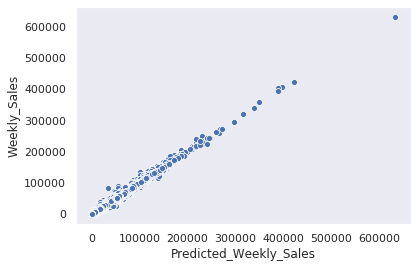

In [125]:
predicted_y_valid =  model_.predict(x_valid)
y_valid['Predicted'] = predicted_y_valid
df_ = pd.merge(train,y_valid[['Predicted']],how = 'left',left_index = True, right_index = True,suffixes=['_True','_Pred'])
df_ = df_[~pd.isnull(df_['Predicted'])]
display(df_.head())
df_['Predicted_Weekly_Sales'] = df_['MedianSales'] - df_['Predicted']
sns.scatterplot(df_['Predicted_Weekly_Sales'], df_['Weekly_Sales'])
# plot_prediction(y_pred_random,y_dev['Difference'].values,"Random Forest")

- バリデーションの予測した売上の結果と、実際の売上が線形な関係にあることから、おおよそ正しく予測できていることが確認できる

### 提出するcsvを作る

In [115]:
# print(study.best_params)
# print(1-study.best_value)
# > {'n_estimators': 850, 'max_depth': 18, 'min_child_weight': 4, 'subsample': 0.9, 'colsample_bytree': 0.7, 'num_leaves': 320}
# > 0.42710110443089855
y_pred = model_.predict(x_valid)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
print(rmse)

1441.543985079116


In [116]:
from datetime import datetime
final_y_prediction = model_.predict(test[FEATURE_COLUMNS])
testfile = pd.concat([test.reset_index(drop=True), pd.DataFrame(final_y_prediction)], axis=1)
testfile.head()

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Phase,Size,Store,Temperature,Type,Unemployment,Weekly_Sales,md1_exists,md2_exists,md3_exists,md4_exists,md5_exists,BlackFriday,Christmas,IsHoliday_False,IsHoliday_True,Black_Friday_False,Black_Friday_True,Christmas_False,Christmas_True,Type_A,Type_B,Type_C,Month,MedianSales,LastWeekDate,LastWeeklySales,ValidLastSales,WeeklyGrowth,ValidGrowth,SalesDiff,Target1,0
0,223.462779,2012-11-02,1,3.386,IsHoliday_False,6766.44,5147.70,50.82,3639.90,2737.42,test,151315,1,55.32,Type_A,6.573,0.0,1,1,1,1,1,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,11,19551.115,2012-10-26,27390.810,1.0,0.290482,1.0,-7839.695,19551.115,-11970.518888
1,223.481307,2012-11-09,1,3.314,IsHoliday_False,11421.32,3370.89,40.28,4646.79,6154.16,test,151315,1,61.24,Type_A,6.573,0.0,1,1,1,1,1,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,11,19551.115,2012-11-02,19551.115,0.0,0.730009,1.0,0.000,19551.115,-794.246486
2,223.512911,2012-11-16,1,3.252,IsHoliday_False,9696.28,292.10,103.78,1133.15,6612.69,test,151315,1,52.92,Type_A,6.573,0.0,1,1,1,1,1,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,11,19551.115,2012-11-09,19551.115,0.0,0.730009,1.0,0.000,19551.115,-4229.455924
3,223.561947,2012-11-23,1,3.211,IsHoliday_True,883.59,4.17,74910.32,209.91,303.32,test,151315,1,56.23,Type_A,6.573,0.0,1,1,1,1,1,Black_Friday_True,Christmas_False,0,1,0,1,1,0,1,0,0,11,19865.770,2012-11-16,19551.115,0.0,0.772267,1.0,314.655,19865.770,-529.103374
4,223.610984,2012-11-30,1,3.207,IsHoliday_False,2460.03,0.00,3838.35,150.57,6966.34,test,151315,1,52.34,Type_A,6.573,0.0,1,0,1,1,1,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,11,19551.115,2012-11-23,19865.770,0.0,0.687256,1.0,-314.655,19551.115,-315.804612


In [117]:
testfile['DateType'] = [datetime.strptime(date, '%Y-%m-%d').date() for date in testfile['Date'].astype(str).values.tolist()]
testfile = testfile.copy().sort_values(["Store", "Dept", "Date"]).reset_index(drop=True)
testfile['prediction'] = testfile.MedianSales - testfile[0]

In [118]:
display(testfile.head())

submission = pd.DataFrame({'Id':pd.Series([x for x in testfile['Store']]).map(str) + '_' +
                           pd.Series([x for x in testfile['Dept']]).map(str)  + '_' +
                           testfile['DateType'].map(str),
                          'Weekly_Sales':testfile['prediction']})
display(submission.head())
submission.to_csv('submission7.csv',index=False)

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Phase,Size,Store,Temperature,Type,Unemployment,Weekly_Sales,md1_exists,md2_exists,md3_exists,md4_exists,md5_exists,BlackFriday,Christmas,IsHoliday_False,IsHoliday_True,Black_Friday_False,Black_Friday_True,Christmas_False,Christmas_True,Type_A,Type_B,Type_C,Month,MedianSales,LastWeekDate,LastWeeklySales,ValidLastSales,WeeklyGrowth,ValidGrowth,SalesDiff,Target1,0,DateType,prediction
0,223.462779,2012-11-02,1,3.386,IsHoliday_False,6766.44,5147.70,50.82,3639.90,2737.42,test,151315,1,55.32,Type_A,6.573,0.0,1,1,1,1,1,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,11,19551.115,2012-10-26,27390.810,1.0,0.290482,1.0,-7839.695,19551.115,-11970.518888,2012-11-02,31521.633888
1,223.481307,2012-11-09,1,3.314,IsHoliday_False,11421.32,3370.89,40.28,4646.79,6154.16,test,151315,1,61.24,Type_A,6.573,0.0,1,1,1,1,1,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,11,19551.115,2012-11-02,19551.115,0.0,0.730009,1.0,0.000,19551.115,-794.246486,2012-11-09,20345.361486
2,223.512911,2012-11-16,1,3.252,IsHoliday_False,9696.28,292.10,103.78,1133.15,6612.69,test,151315,1,52.92,Type_A,6.573,0.0,1,1,1,1,1,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,11,19551.115,2012-11-09,19551.115,0.0,0.730009,1.0,0.000,19551.115,-4229.455924,2012-11-16,23780.570924
3,223.561947,2012-11-23,1,3.211,IsHoliday_True,883.59,4.17,74910.32,209.91,303.32,test,151315,1,56.23,Type_A,6.573,0.0,1,1,1,1,1,Black_Friday_True,Christmas_False,0,1,0,1,1,0,1,0,0,11,19865.770,2012-11-16,19551.115,0.0,0.772267,1.0,314.655,19865.770,-529.103374,2012-11-23,20394.873374
4,223.610984,2012-11-30,1,3.207,IsHoliday_False,2460.03,0.00,3838.35,150.57,6966.34,test,151315,1,52.34,Type_A,6.573,0.0,1,0,1,1,1,Black_Friday_False,Christmas_False,1,0,1,0,1,0,1,0,0,11,19551.115,2012-11-23,19865.770,0.0,0.687256,1.0,-314.655,19551.115,-315.804612,2012-11-30,19866.919612


,Id,Weekly_Sales
0,1_1_2012-11-02,31521.633888
1,1_1_2012-11-09,20345.361486
2,1_1_2012-11-16,23780.570924
3,1_1_2012-11-23,20394.873374
4,1_1_2012-11-30,19866.919612
